# Multi Armed Bandits

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-set-up-class" data-toc-modified-id="Imports-and-set-up-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and set up class</a></span></li><li><span><a href="#Random-allocation" data-toc-modified-id="Random-allocation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random allocation</a></span></li><li><span><a href="#$\epsilon$-greedy-allocation" data-toc-modified-id="$\epsilon$-greedy-allocation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>$\epsilon$-greedy allocation</a></span></li><li><span><a href="#Thompson-sampled-allocation" data-toc-modified-id="Thompson-sampled-allocation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Thompson-sampled allocation</a></span></li><li><span><a href="#Delayed-$\epsilon$-greedy" data-toc-modified-id="Delayed-$\epsilon$-greedy-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Delayed $\epsilon$-greedy</a></span></li><li><span><a href="#Closer-proportions-in-the-variants" data-toc-modified-id="Closer-proportions-in-the-variants-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Closer proportions in the variants</a></span></li><li><span><a href="#Plotly-express-animation-(not-used)" data-toc-modified-id="Plotly-express-animation-(not-used)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotly express animation (not used)</a></span></li><li><span><a href="#Visual-for-explanation" data-toc-modified-id="Visual-for-explanation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visual for explanation</a></span></li><li><span><a href="#Visual-for-the-multi-variant-version" data-toc-modified-id="Visual-for-the-multi-variant-version-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Visual for the multi-variant version</a></span></li><li><span><a href="#Print-multiple-simulations" data-toc-modified-id="Print-multiple-simulations-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Print multiple simulations</a></span></li><li><span><a href="#Charts-for-blog" data-toc-modified-id="Charts-for-blog-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Charts for blog</a></span></li></ul></div>

This notebook covers simulations of "Multi Armed Bandit" campaigns, which are akin to multi-variant A/B tests, except that the proportion of users placed in each variant changes over time to try to optimise some output metric throughout the experiment (at the detriment of statistical significance)

For more details on Thompson sampling, see [here](https://arxiv.org/pdf/1707.02038.pdf)

Originally read [this](https://vwo.com/blog/multi-armed-bandit-algorithm/) post

We first define the simulation class, which contains methods for running the simulation, and plotting both static & animated outputs.

We then create a few specific charts for a Medium post [here](https://medium.com/@paulgstubley/a-visual-exploration-of-multi-armed-bandit-experiments-278f1f15c4f1)

## Imports and set up class

In [101]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.special import gamma
import sys
import os

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import ffmpeg
from matplotlib import animation, rc, rcParams, gridspec
from IPython.display import HTML, Image
from matplotlib.animation import FFMpegWriter
plt.rcParams['animation.ffmpeg_path'] = '/Users/paulgstubley/Applications/ffmpeg/bin/ffmpeg'

# Define example proportions
proportions = [0.1,0.2,0.15,0.3,0.05]

# Save default color list for use later
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [6]:
class simulation():
    '''This class covers Multi Armed Bandit objects, including running the simulation and plotting the output'''
    
    def __init__(self, iterations = 10_000, sim_type='random', proportions = [0.1,0.2,0.15,0.3,0.05], epsilon = None):
        '''
        sim_type - (str) one of 'random', 'egreedy', 'slow_greedy', 'Thompson'
        see https://arxiv.org/pdf/1707.02038.pdf for a description of Thompson sampling
        '''
        self.sim_type = sim_type
        self.proportions = proportions
        self.epsilon = epsilon
        self.iterations = iterations

        self.n_bandits = len(self.proportions)
        self.variants = np.arange(self.n_bandits)

        self.results = np.empty((self.iterations,8))
        self.results[:] = np.NaN
        self.count_per_bandit = np.zeros(self.n_bandits)
        self.mean_per_bandit  = np.ones(self.n_bandits)*0.5
        self.stddev_per_bandit = np.zeros(self.n_bandits)
                
        # Successes - \alpha in the literature
        self.successes = np.ones(self.n_bandits)
        # Failures - \beta in the literature
        self.failures = np.ones(self.n_bandits)


    def _choose(self, person):
        '''Choose a variant in one of a number of ways defined by self.sim_type'''
        if self.sim_type=='random':
            return np.random.choice(self.variants)
        elif (self.sim_type=='egreedy') | (self.sim_type=='slow_greedy'):
            # Ramp epsilon down from 1 if early in the simulation for slow_greedy 
            if self.sim_type=='slow_greedy':
                epsilon = (np.exp(-person/1000)+self.epsilon) # Note this will be above 1 at early time, but this doesn't matter to us
            else:
                epsilon = self.epsilon
                
            # 5% random sample, otherwise pick best according to current means
            if np.random.random() < epsilon:
                return np.random.choice(self.variants)
            else:
                return np.argmax(self.mean_per_bandit)
            
        elif self.sim_type=='Thompson':
            return np.argmax(self.mean_per_bandit)

    def run_simulation(self, verbose=True):
        '''Runs the simulation for `self.iterations` loops'''
        if verbose: print('Running simulation...',end='')
        for person in range(self.iterations):
            # Place person into one of the variants at random
            variant = self._choose(person) 
            outcome = np.random.binomial(1,self.proportions[variant])
            
            # Update successes/failures
            self.successes[variant] += outcome
            self.failures[variant] += 1-outcome
            
            # Get probabilities
            self.count_per_bandit[variant] = self.successes[variant]+self.failures[variant]

            if self.sim_type == 'Thompson':
                # If Thompson sampling, set the mean to a single sample from a beta-distribution defined by the current successes/failure counts
                for v in self.variants:
                    self.mean_per_bandit[v] = np.random.beta(self.successes[v], self.failures[v])
            else:
                # Else calculate the arithmatic mean
                self.mean_per_bandit[variant] = self.successes[variant]/(self.count_per_bandit[variant])
               
            self.stddev_per_bandit[variant] = np.sqrt(self.mean_per_bandit[variant]*(1-self.mean_per_bandit[variant])/self.count_per_bandit[variant])

            self.results[person] = [person, variant, outcome, self.count_per_bandit[variant], self.mean_per_bandit[variant], self.stddev_per_bandit[variant], self.successes[variant], self.failures[variant]]
        
        self.results_df = pd.DataFrame(self.results, columns=['Iteration','Variant','Outcome','Variant_Count','Variant_Mean','Variant_Stddev','Successes','Failures'])

        if verbose: print('Done')
        return self.results
    
    
    def plot_simulation_output(self, verbose=True):
        '''Plots a multiplot of the simulation output'''

        if verbose: print('Plotting...',end='')

        df = self.results_df
        df.Variant = df.Variant.astype('category')
        
        fig,ax = plt.subplots(4,1,figsize=(10,10), dpi=160, gridspec_kw={'height_ratios': [1,3,4,3]})

        # Axis formatting
        ax[0].set_ylabel('Variant')
        ax[0].set_title('Variant allocation through time')
        ax[0].set_yticks(self.variants)
        lims = min(self.variants)-1,max(self.variants)+1
        ax[0].set_ylim(lims)

        ax[1].set_title('Variant ratios through time')
        ax[1].set_ylabel('Ratio of variants')


        ax[2].set_title('Variant means through time')
        ax[2].set_ylabel('Estimated Mean')
        ax[2].set_yticks(np.arange(0,1,0.2))

        ax[3].set_ylabel('Capture')
        ax[3].set_ylim([0,1.2])
        
        for a in ax[:-1]:
            a.set_xticklabels([])
        ax[-1].set_xlabel('Iteration')

        for a in ax:
            a.set_xlim([-self.iterations/20,self.iterations*1.1])
            
        groups = df.groupby("Variant")
        # Scatter of variant choices
        for name, group in groups:
            ax[0].plot(group["Iteration"], group["Variant"], marker="|", linestyle="", label=name)
            # Swarm plot takes a while to plot
            #sns.swarmplot(group["Iteration"], group["Variant"], ax = ax[0])

        # Stacked area of variant choice proportions
        stacks = df.pivot(index='Iteration',columns='Variant',values='Variant_Count').ffill().fillna(0)
        # Normalise by row
        stacks = stacks.apply(lambda x: x/sum(x), axis=1)
        ax[1].stackplot(stacks.index,  stacks.values.T, alpha = 0.8);
        # Annotate final sample ratios
        y_loc = 0
        for i, j in enumerate(stacks.values[-1]):
            y_loc += j/2
            ax[1].annotate('{:0.2f}'.format(j),(self.iterations*1.005,y_loc), color=colors[i], va='center')
            y_loc += j/2

        # Lineplot of estimates of variant means 
        for i in self.variants:
            data = df[df.Variant==i]
            if self.sim_type=='Thompson':
                line, = ax[2].plot('Iteration', 'Variant_Mean',data=data, marker='.', ms=2, lw=0)
            else:
                line, = ax[2].plot('Iteration', 'Variant_Mean',data=data)
            # Annotate final means
            x,y = self.iterations*1.005,line.get_ydata()[-1]

            ax[2].fill_between(data.Iteration
                            , data.Successes/(data.Successes+data.Failures) - 2*data.Variant_Stddev
                            , data.Successes/(data.Successes+data.Failures) + 2*data.Variant_Stddev
                            , color=colors[i], alpha=0.1)
            
            ax[2].annotate('{:0.2f} (c: {:0.2f})'.format(y, self.proportions[i]),(x,y), color=colors[i])

        ax[2].set_ylim([0,df.Variant_Mean.max()*1.2]);
        
        # Capture (%age of max expectation) plot
        exp_best = df.Iteration*max(self.proportions)
        current_score = df.Outcome.cumsum()
        capture = current_score/exp_best
        regret = (exp_best - current_score)/exp_best
        line, = ax[3].plot(capture, c='k', ls='--')
        x,y = line.get_xdata()[-1],line.get_ydata()[-1]
        ax[3].annotate('{:0.2f}'.format(y),(x+self.iterations/150,y), va='center')
        if verbose: print('Done')
        
        
    def animate(self, frames = 100, verbose = True):
        '''Sets the anim property of self to a Matplotlib animation object showing the distributions through time'''
        
        def init():
            return (*lines,)

        def update(i,n,verbose,frames):
            for v in range(n):
                if (self.sim_type == 'egreedy') | (self.sim_type =='slow_greedy'):
                    mean = a_list[v][i]/(a_list[v][i]+b_list[v][i])
                    lines[v].set_data([mean,mean],[0,1]) 
                else:
                    lines[v].set_data([x,stats.beta.pdf(x, a_list[v][i], b_list[v][i])])  
                bar_failure[v].set_height(b_list[v][i])
                bar_success[v].set_height(a_list[v][i])

                text_failure[v].set_position((v, b_list[v][i]))
                text_success[v].set_position((v+0.35, a_list[v][i]))
                text_failure[v].set_text(b_list[v][i])
                text_success[v].set_text(a_list[v][i])
            
            label.set_text('Iteration: {}'.format(i+1))

            if verbose:
                p = int(i/frames*100)
                if p>last_printed:
                    print('\rPercent: {p:3d}'.format(p=p), end='')
                    sys.stdout.flush()
            return (*lines,)
        
        def format_charts(ax):
            ax[0].set_ylim([0,10])
            ax[0].set_yticks([])
            ax[0].set_title('Probability Density Functions')
            ax[0].set_xlabel('Proportion')

            ax[1].set_title('Counts')
            ax[1].set_yticks([])

            for spine in ['top','left','right']:
                ax[0].spines[spine].set_visible(False)
                ax[1].spines[spine].set_visible(False)
        
        last_printed = 0
        fig, ax = plt.subplots(figsize = (15,5))
        gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[5, 1])  # Have thin bottom row to allow space for xlabel in gif (bug stops labels printing correctly otherwise)
        label = fig.text(0.8,0.1,'Iteration: ', ha='left')

        ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

        x = np.linspace(0,1, 100)

        df = pd.DataFrame(self.results, columns=['Iteration','Variant','Outcome','Variant_Count','Variant_Mean','Variant_Stddev','Successes','Failures'])
        # Reshape dataframe to have one column per variant split by success/failure

        stacks = df.pivot(index='Iteration',columns='Variant',values=['Successes','Failures']).ffill().fillna(1).iloc[:frames]

        a_list = stacks.Successes.astype(int)
        b_list = stacks.Failures.astype(int)

        # Get highest value in all distributions for ylim
        idx = (stacks.max().Successes+stacks.max().Failures).argmax()

        # Approx ylim
        if (self.sim_type == 'egreedy') | (self.sim_type == 'slow_greedy'):
            ymax = 1
            ax[0].set_xlim([-0.04,1])
        else:
            ymax = 1.5*stats.beta.pdf(x, stacks.Successes[idx].tail(1), stacks.Failures[idx].tail(1)).max()
        ax[0].annotate('Population Proportions →       ',(0,ymax*0.85), va='center', ha='right', c='grey')
    
        lines = []
        bar_failure = []
        bar_success = []
        text_failure = []
        text_success = []

        # Set up each chart and line
        for v in self.variants:
            ax[0].axvline(self.proportions[v],0.8,0.9, ls=':', color = colors[v])
            if (self.sim_type == 'egreedy') | (self.sim_type == 'slow_greedy'):
                lines.append(ax[0].plot([0.5,0.5],[0,1])[0])
            else:
                lines.append(ax[0].plot(x,stats.beta.pdf(x, 1, 1))[0])
            bar_failure.append(ax[1].bar(v, 1, color='w', edgecolor = colors[v], lw =3, width=0.5, hatch='X')[0])
            bar_success.append(ax[1].bar(v+0.25, 1, facecolor=colors[v], edgecolor=colors[v], lw =3, width=0.5)[0])
            text_failure.append(ax[1].annotate(1,(v,1), va='bottom', ha='center', color = colors[v]))
            text_success.append(ax[1].annotate(1,(v+0.35,1), va='bottom',ha='left', color =colors[v]))

        format_charts(ax)
        ax[1].set_xticks(self.variants+0.125)
        ax[1].set_xticklabels(self.variants, rotation=0)

        # Set the ylimits
        ax[1].set_ylim([0,stacks.max(axis=0).max()*1.2])
        ax[0].set_ylim([0,ymax])

        # Create the animation
        self.anim = animation.FuncAnimation(fig, update, init_func=init,
                                       frames=frames, interval=10,
                                       fargs=(len(self.variants),verbose,frames),
                                       blit=True, repeat=None)

        if verbose:
            print('\rPercent: {:3d}'.format(100), end='')
            sys.stdout.flush()

    

## Random allocation

As in a traditional multi-variate test

Running simulation...Done
Plotting...Done


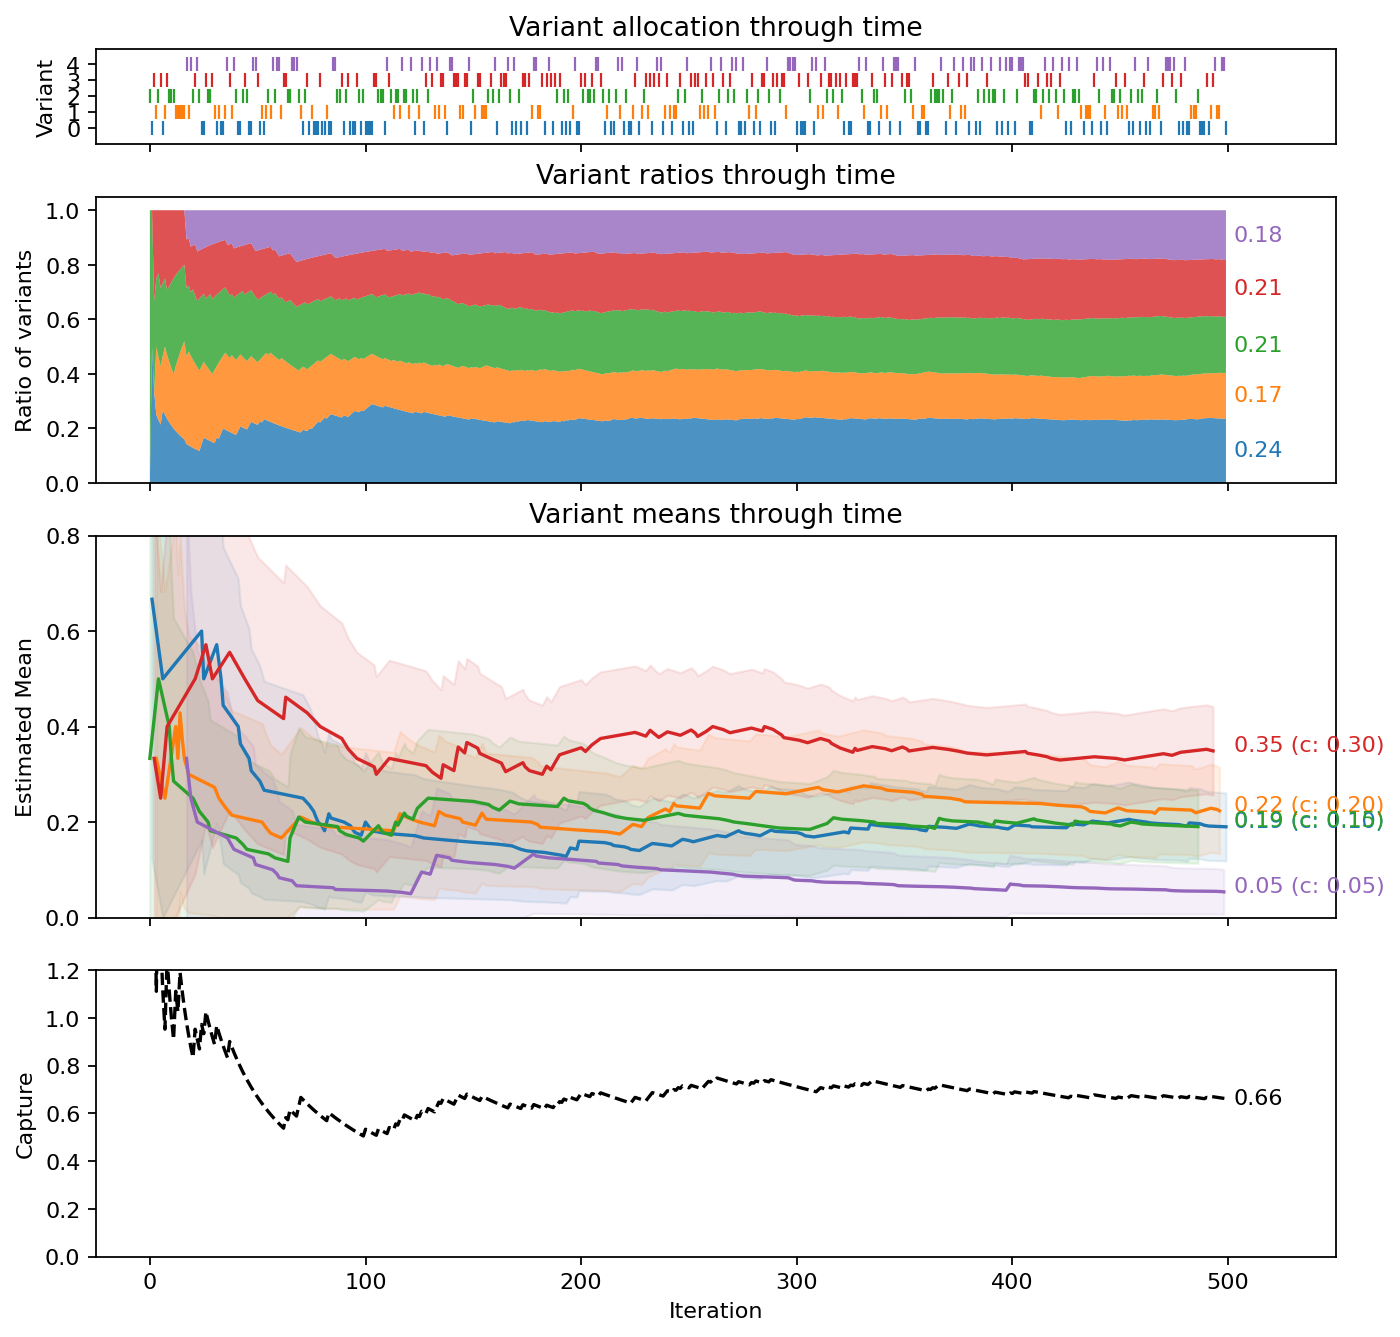

In [102]:
random = simulation(iterations=500)
random.run_simulation()
random.plot_simulation_output()


## $\epsilon$-greedy allocation

Running simulation...Done
Plotting...Done


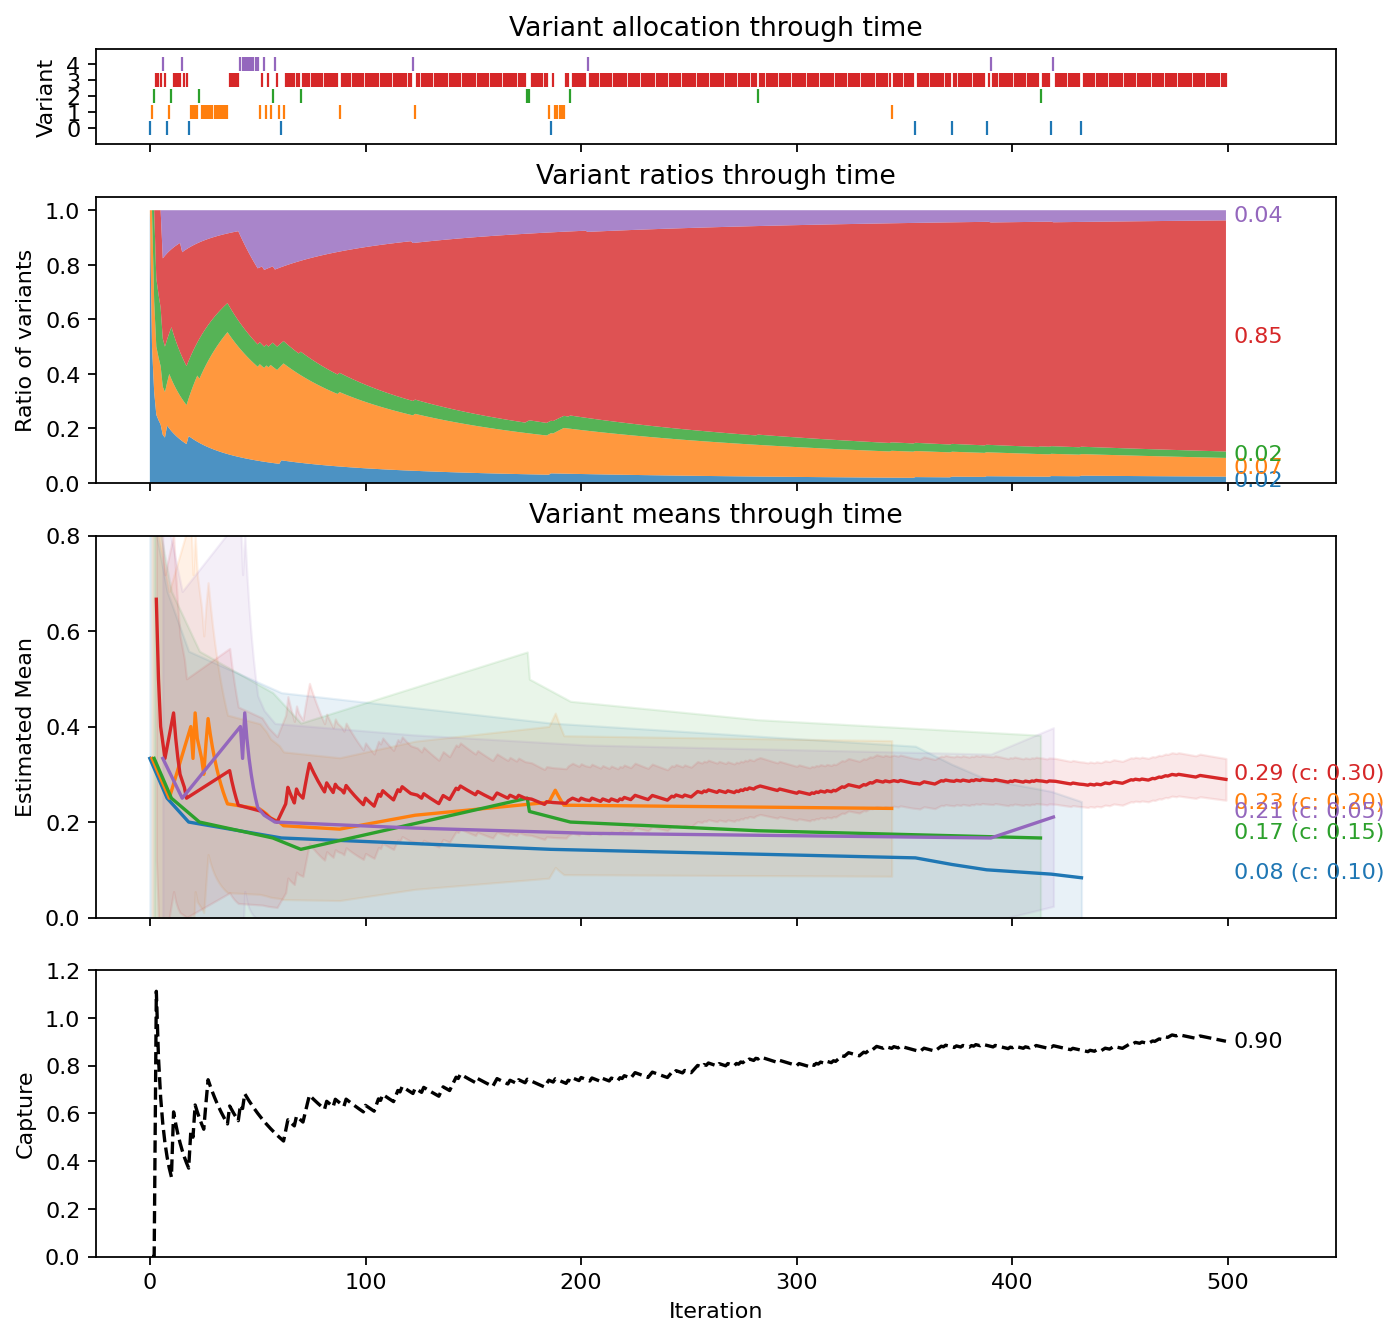

In [626]:
egreedy = simulation(sim_type='egreedy', epsilon = 0.05, iterations=500)
egreedy.run_simulation()
egreedy.plot_simulation_output()

## Thompson-sampled allocation

Running simulation...Done
Plotting...Done


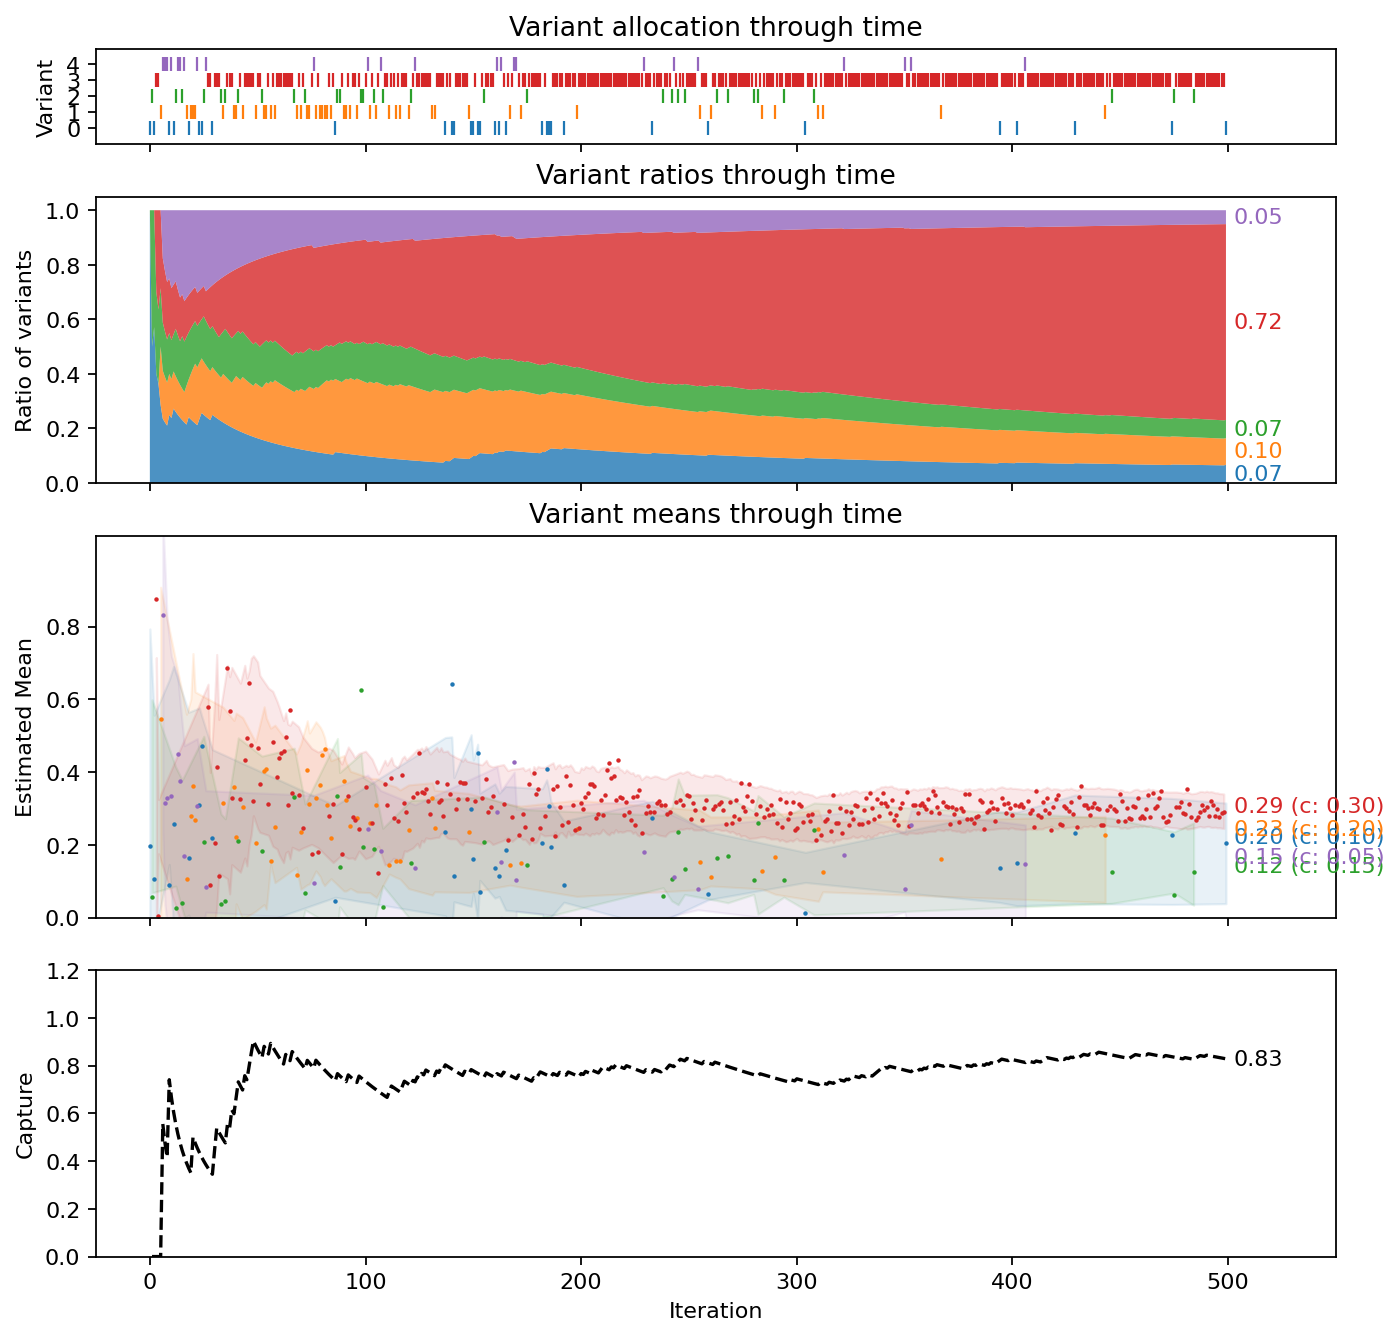

In [8]:
thompson = simulation(sim_type='Thompson', iterations=500)
thompson.run_simulation()
thompson.plot_simulation_output()

## Delayed $\epsilon$-greedy

This section uses a decaying $\epsilon$ to try to avoid getting stuck in the wrong variant

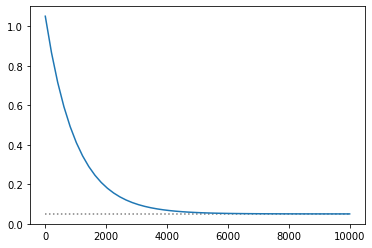

In [648]:
x = np.linspace(0,10_000)
base_epsilon = 0.05

epsilon = (np.exp(-x /1000)+base_epsilon)
plt.plot(x,epsilon)
plt.hlines(base_epsilon,0,10_000, color='grey',ls=':')

Running simulation...Done
Plotting...Done


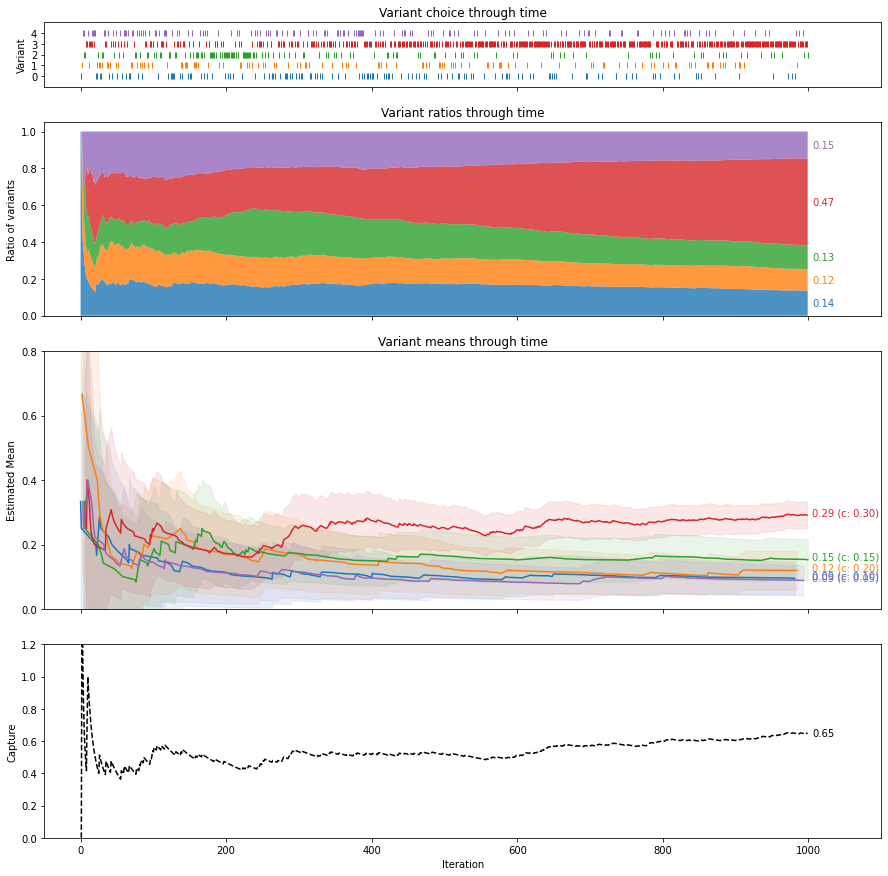

In [484]:
slow_greedy = simulation(sim_type='slow_greedy', epsilon = 0.05, iterations=1_000)
slow_greedy.run_simulation()
slow_greedy.plot_simulation_output()

## Closer proportions in the variants

In these examples, egreedy gets stuck on a sub-optimal variant, whereas the slow-greedy finds the correct one

Running simulation...Done
Plotting...Done


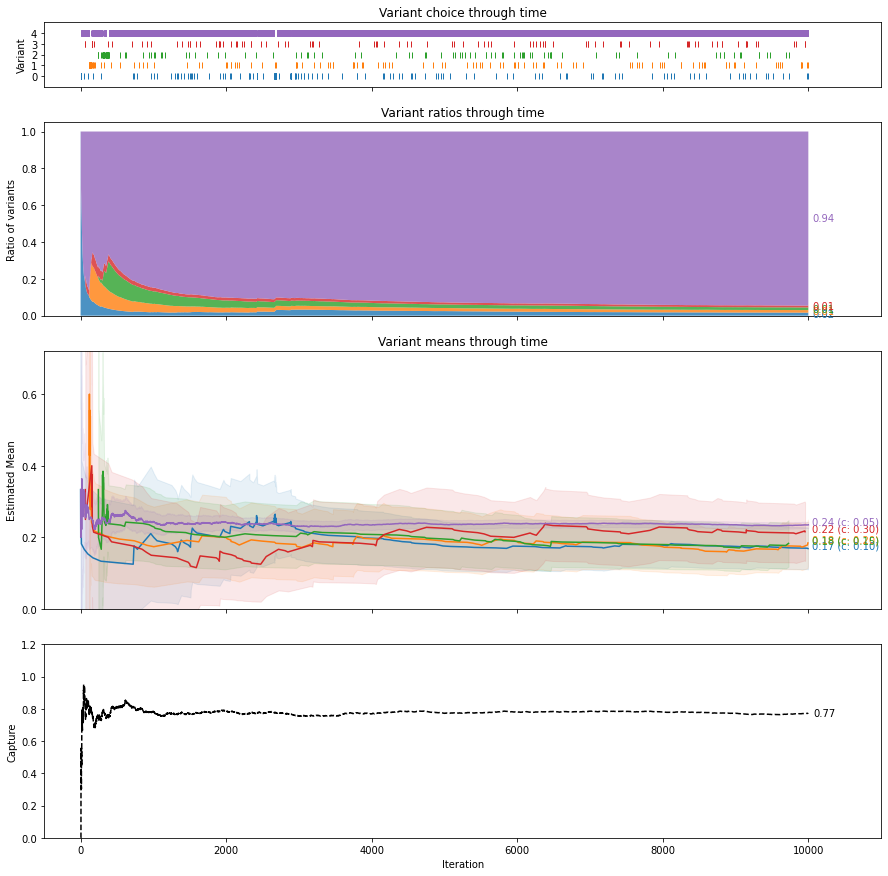

In [319]:
egreedy = simulation(iterations = 10_000, sim_type='egreedy', epsilon = 0.05, proportions = [0.2,0.21,0.22,0.23,0.24])
egreedy.run_simulation()
egreedy.plot_simulation_output()

Running simulation...Done
Plotting...Done


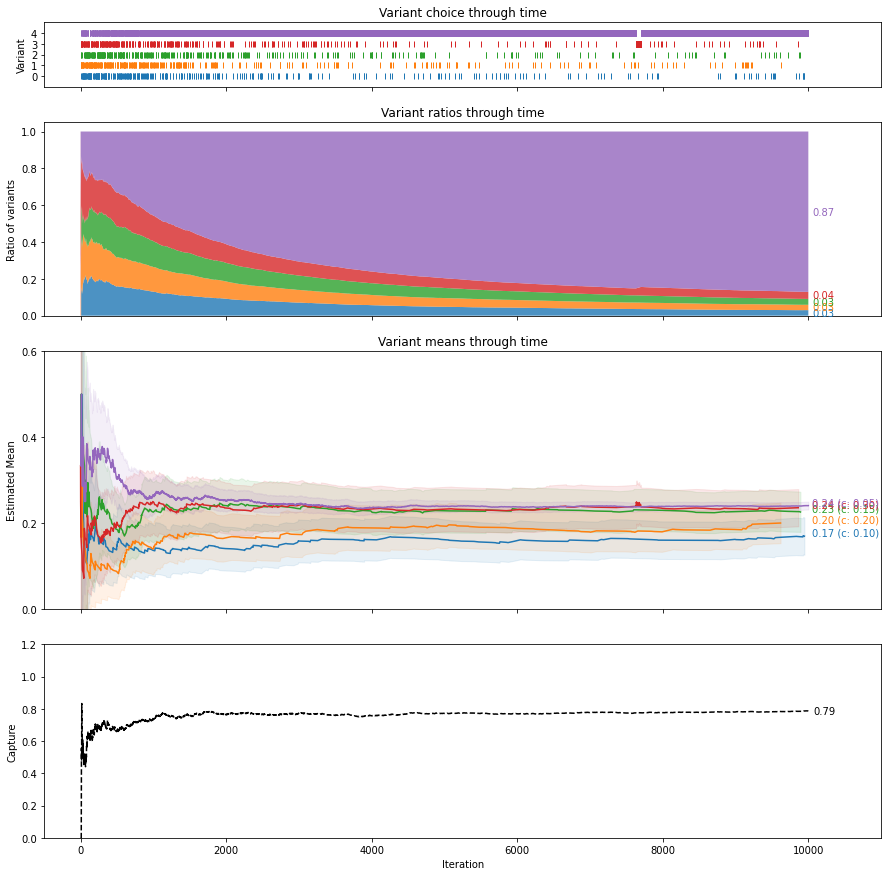

In [395]:
slow_greedy = simulation(iterations = 10_000, sim_type='slow_greedy', epsilon = 0.05, proportions = [0.2,0.21,0.22,0.23,0.24])
slow_greedy.run_simulation()
slow_greedy.plot_simulation_output()

## Plotly express animation (not used)

I decided against plotting them this way, but saved for future use

In [103]:
import plotly.express as px
#fig, ax = plt.subplots(1, 1)
a=1
b=1
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)

results = [np.array([[0]*len(x),x,stats.beta.pdf(x, a, b)]).T]


for i in range(1,400):
    outcome = np.random.binomial(1,0.2)
    a += outcome
    b += 1-outcome
    if i<=40:
        results.append(np.array([[i]*len(x),x,stats.beta.pdf(x, a, b)]).T)   
    elif i%40==0:
        results.append(np.array([[i]*len(x),x,stats.beta.pdf(x, a, b)]).T)   

df = pd.DataFrame(np.concatenate(results), columns=['iteration','x','beta']).sort_values(['iteration','x'])

fig = px.line(df, x='x', y='beta', animation_frame='iteration',range_y=[0,10])

fig.show()


## Visual for explanation


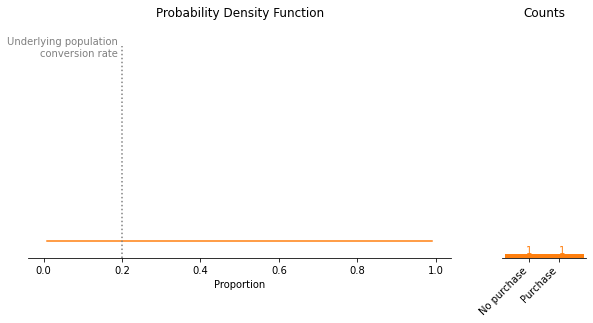

In [540]:
import matplotlib.pyplot as plt
import ffmpeg
import os
from matplotlib import animation, rc, rcParams, gridspec
from IPython.display import HTML, Image
from matplotlib.animation import FFMpegWriter
import sys

# Set the FFmpeg path and defaults for display
plt.rcParams['animation.ffmpeg_path'] = '/Users/paulgstubley/Applications/ffmpeg/bin/ffmpeg'
proportion = 0.2

fig, ax = plt.subplots(figsize = (10,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[20, 1])  # Have thin bottom row to allow space for xlabel in gif (bug stops labels printing correctly otherwise)

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

a=1
b=1
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)

color = 'C1'
line, = ax[0].plot(x,stats.beta.pdf(x, a, b),color=color);


def format_charts(ax):
    ax[0].set_ylim([0,10])
    ax[0].set_yticks([])
    ax[0].set_title('Probability Density Function')
    ax[0].set_xlabel('Proportion')

    ax[1].set_title('Counts')
    ax[1].set_yticks([])
    
    for spine in ['top','left','right']:
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)

ax[1].set_xticklabels(['','No purchase','Purchase'], rotation=45, ha='right')
ax[0].axvline(proportion,0,0.9, ls=':', color = 'grey')
ax[0].annotate('Underlying population\nconversion rate', (0.19,12), c='grey', ha='right')

format_charts(ax)
bar, = ax[1].bar(0, b, facecolor='w',  edgecolor = color, lw =3, hatch='X')
bar2, = ax[1].bar(0.5, a,color=color ,  edgecolor=color, lw =3)

text =  ax[1].annotate(b,(0,b), va='bottom', ha='center', color = color)
text2 = ax[1].annotate(a,(0.5,a), va='bottom', color = color)


def init():

    return (line,)

def update(i):
    global a
    global b
    line.set_data([x,stats.beta.pdf(x, a, b)])   
    bar.set_height(b)
    bar2.set_height(a)
    
    text.set_position((0, b))
    text2.set_position((0.5, a))
    text.set_text(b)
    text2.set_text(a)
    
    outcome = np.random.binomial(1,proportion)
    a += outcome
    b += 1-outcome

    return (line,)

frames = 100
ax[1].set_ylim([0,frames])
ax[0].set_ylim([0,14])

anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=frames, interval=50,
                               blit=True, repeat=None)



#HTML(anim.to_html5_video())


In [541]:
# Save the explanation animation and add delay to gif loop
anim.save('assets/lines.gif', writer='imagemagick')
os.system('convert assets/lines.gif \( +clone -set delay 500 \) +swap +delete  assets/lines_pause.gif')


## Visual for the multi-variant version

In [ ]:
thompson.animate(1000)
HTML(thompson.anim.to_html5_video())


In [ ]:
random.animate(1000)
HTML(random.anim.to_html5_video())

Percent:  99

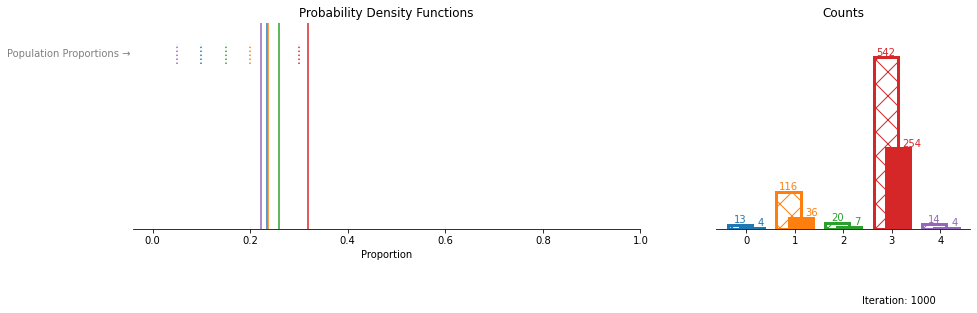

In [444]:
egreedy.animate(1000)
HTML(egreedy.anim.to_html5_video())

## Print multiple simulations

This section shows how each method works over many simuations, highlighting $\epsilon$-greedy getting stuck on sub-optimal variants occasionally

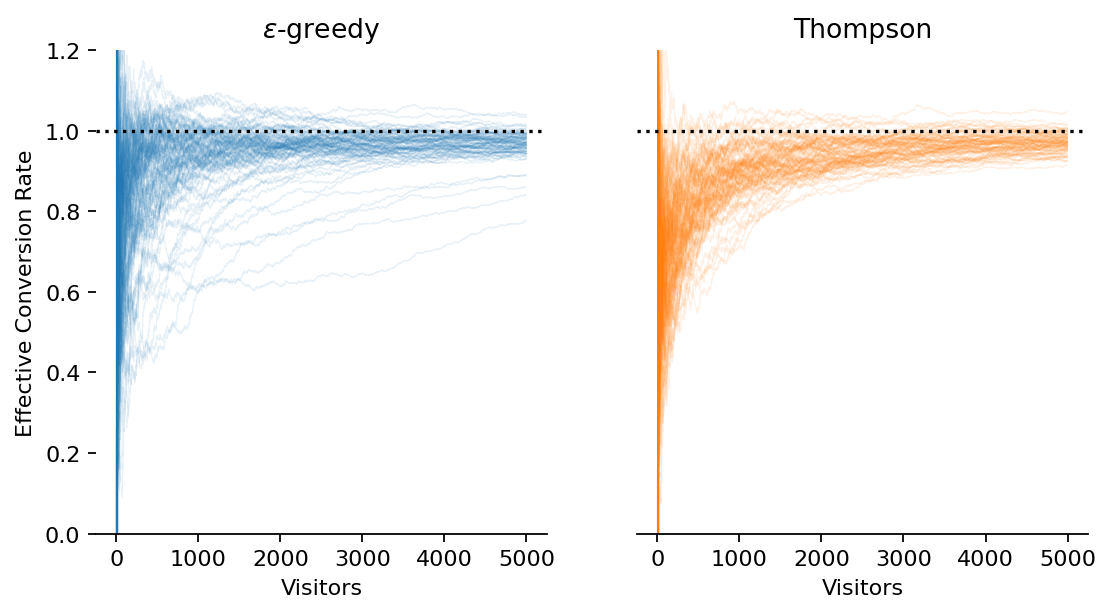

In [42]:
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=160)

for a,sim_type in enumerate(['egreedy','Thompson']):
    for i in range(100):
        egreedy = simulation(iterations = 5_000, sim_type=sim_type, epsilon = 0.05)
        egreedy.run_simulation(verbose=False)

        exp_best = egreedy.results_df.Iteration*max(proportions)
        current_score = egreedy.results_df.Outcome.cumsum()
        capture = current_score/exp_best
        line, = ax[a].plot(capture, c='C'+str(a), ls='-', lw=0.5, alpha=0.1)

    ax[a].set_ylim([0,1.2])
    ax[a].axhline(1, c='k',ls=':')
    ax[a].set_xlabel('Visitors')

    for spine in ['top','left','right']:
        ax[a].spines[spine].set_visible(False)

ax[0].set_ylabel('Effective Conversion Rate')
ax[1].set_yticks([])
ax[0].set_title('$\epsilon$-greedy')
ax[1].set_title('Thompson');


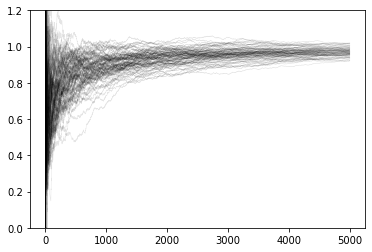

In [25]:
fig, ax = plt.subplots(1,1)

for i in range(100):
    thompson = simulation(iterations = 5_000, sim_type='Thompson', epsilon = 0.05)
    thompson.run_simulation(verbose=False)

    exp_best = thompson.results_df.Iteration*max(proportions)
    current_score = thompson.results_df.Outcome.cumsum()
    capture = current_score/exp_best
    line, = ax.plot(capture, c='k', ls='-', lw=0.5, alpha=0.1)

ax.set_ylim([0,1.2]);


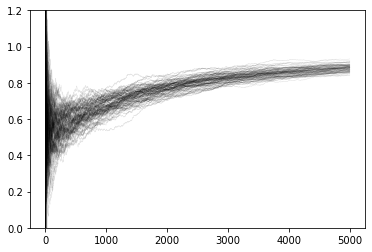

In [483]:
fig, ax = plt.subplots(1,1)

for i in range(100):
    egreedy = simulation(iterations = 5_000, sim_type='slow_greedy', epsilon = 0.05)
    egreedy.run_simulation(verbose=False)

    exp_best = egreedy.results_df.Iteration*max(proportions)
    current_score = egreedy.results_df.Outcome.cumsum()
    capture = current_score/exp_best
    line, = ax.plot(capture, c='k', ls='-', lw=0.5, alpha=0.1)

ax.set_ylim([0,1.2]);

## Charts for blog

This section just creates specific charts for the blog post

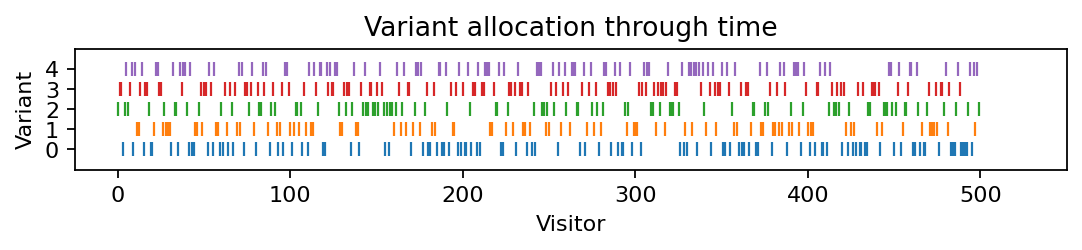

In [511]:
self = random
df = self.results_df
df.Variant = df.Variant.astype('category')

fig,ax = plt.subplots(1,1,figsize=(8,1), dpi=160)

# Axis formatting
ax.set_ylabel('Variant')
ax.set_title('Variant allocation through time')
ax.set_yticks(self.variants)
lims = min(self.variants)-1,max(self.variants)+1
ax.set_ylim(lims)

ax.set_xlabel('Visitor')

ax.set_xlim([-self.iterations/20,self.iterations*1.1])

groups = df.groupby("Variant")
# Scatter of variant choices
for name, group in groups:
    ax.plot(group["Iteration"], group["Variant"], marker="|", linestyle="", label=name)
    # Swarm plot takes a while to plot
    #sns.swarmplot(group["Iteration"], group["Variant"], ax = ax[0])



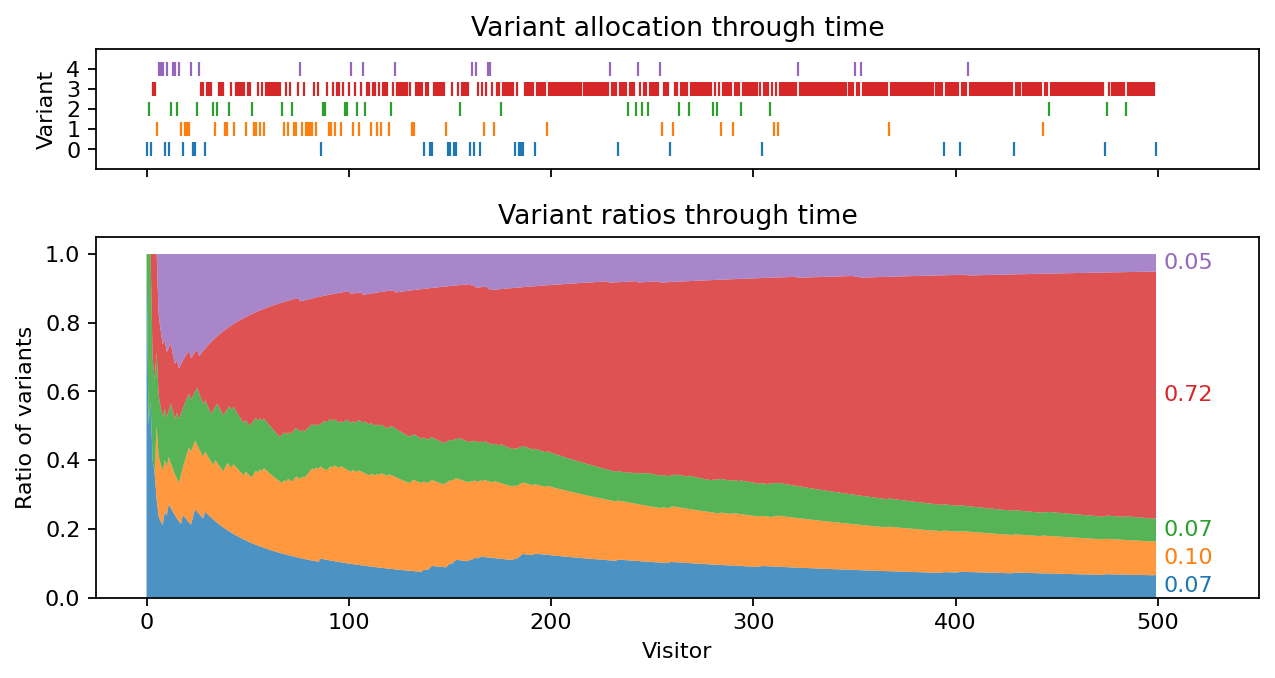

In [20]:
self = thompson

df = self.results_df
df.Variant = df.Variant.astype('category')

fig,ax = plt.subplots(2,1,figsize=(8,4), dpi=160, gridspec_kw={'height_ratios': [1,3]})
fig.tight_layout()
#plt.grid(axis='x')

#ax.yticks(range(len(proportions)))
# Axis formatting
ax[0].set_ylabel('Variant')
ax[0].set_title('Variant allocation through time')
ax[0].set_yticks(self.variants)
lims = min(self.variants)-1,max(self.variants)+1
ax[0].set_ylim(lims)

ax[1].set_title('Variant ratios through time')
ax[1].set_ylabel('Ratio of variants')

for a in ax[:-1]:
    a.set_xticklabels([])
ax[-1].set_xlabel('Visitor')

for a in ax:
    a.set_xlim([-self.iterations/20,self.iterations*1.1])

groups = df.groupby("Variant")
# Scatter of variant choices
for name, group in groups:
    ax[0].plot(group["Iteration"], group["Variant"], marker="|", linestyle="", label=name)
    # Swarm plot takes a while to plot
    #sns.swarmplot(group["Iteration"], group["Variant"], ax = ax[0])

# Stacked area of variant choice proportions
stacks = df.pivot(index='Iteration',columns='Variant',values='Variant_Count').ffill().fillna(0)
# Normalise by row
stacks = stacks.apply(lambda x: x/sum(x), axis=1)
ax[1].stackplot(stacks.index,  stacks.values.T, alpha = 0.8);
# Annotate final sample ratios
y_loc = 0
for i, j in enumerate(stacks.values[-1]):
    y_loc += j/2
    ax[1].annotate('{:0.2f}'.format(j),(self.iterations*1.005,y_loc), color=colors[i], va='center')
    y_loc += j/2

In [645]:
counts = np.array(df.groupby('Variant').Variant_Count.max().to_list())

In [646]:
egreedy.proportions

[0.1, 0.2, 0.15, 0.3, 0.05]

In [649]:
(counts*np.array(egreedy.proportions)).sum()

140.54999999999998

Percent:  99

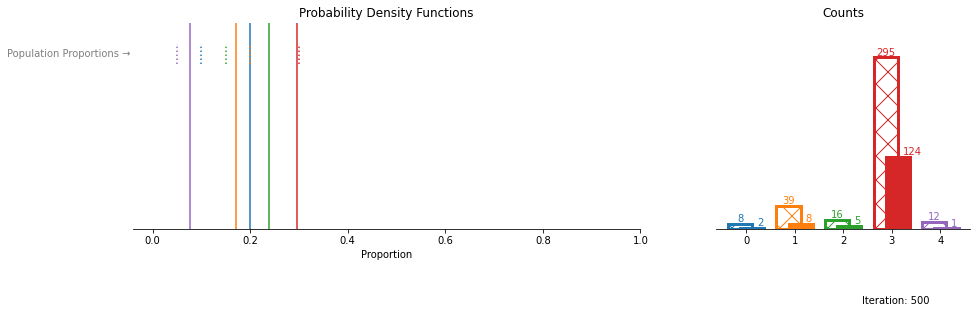

In [606]:
anim = egreedy.animate(500)


Percent: 100

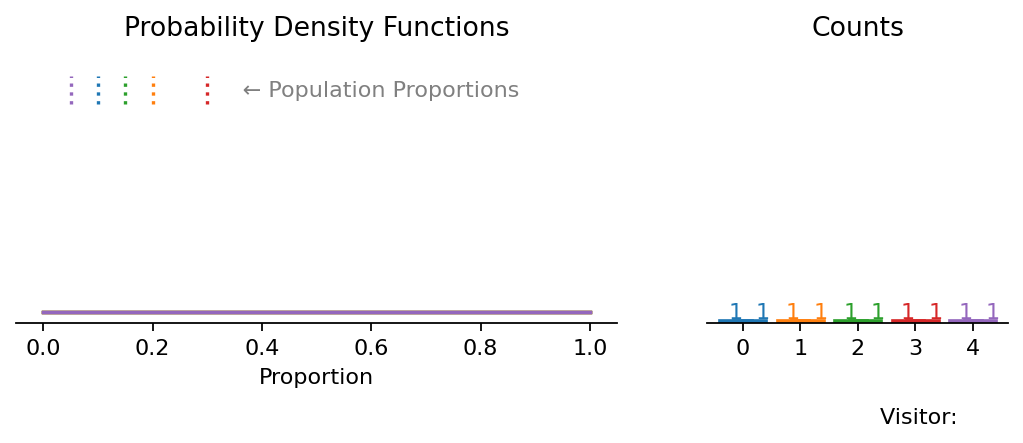

In [16]:
self = thompson
frames = 500
verbose = True
def init():
    return (*lines,)

def update(i,n,verbose,frames):
    for v in range(n):
        lines[v].set_data([x,stats.beta.pdf(x, a_list[v][i], b_list[v][i])])  
        bar_failure[v].set_height(b_list[v][i])
        bar_success[v].set_height(a_list[v][i])

        text_failure[v].set_position((v, b_list[v][i]))
        text_success[v].set_position((v+0.35, a_list[v][i]))
        text_failure[v].set_text(b_list[v][i])
        text_success[v].set_text(a_list[v][i])

    label.set_text('Visitor: {}'.format(i+1))

    if verbose:
        p = int(i/frames*100)
        if p>last_printed:
            print('\rPercent: {p:3d}'.format(p=p), end='')
            sys.stdout.flush()
    return (*lines,)

def format_charts(ax):
    ax[0].set_ylim([0,10])
    ax[0].set_yticks([])
    ax[0].set_title('Probability Density Functions')
    ax[0].set_xlabel('Proportion')

    ax[1].set_title('Counts')
    ax[1].set_yticks([])

    for spine in ['top','left','right']:
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)

last_printed = 0
fig, ax = plt.subplots(figsize = (8,3), dpi=160)
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[5, 1])  # Have thin bottom row to allow space for xlabel in gif (bug stops labels printing correctly otherwise)
label = fig.text(0.8,0.1,'Visitor: ', ha='left')

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

x = np.linspace(0,1, 100)

df = pd.DataFrame(self.results, columns=['Iteration','Variant','Outcome','Variant_Count','Variant_Mean','Variant_Stddev','Successes','Failures'])
# Reshape dataframe to have one column per variant split by success/failure

stacks = df.pivot(index='Iteration',columns='Variant',values=['Successes','Failures']).ffill().fillna(1).iloc[:frames]

a_list = stacks.Successes.astype(int)
b_list = stacks.Failures.astype(int)

# Get highest value in all distributions for ylim
idx = (stacks.max().Successes+stacks.max().Failures).argmax()

# Approx ylim
ymax = 1.5*stats.beta.pdf(x, stacks.Successes[idx].tail(1), stacks.Failures[idx].tail(1)).max()
ax[0].annotate('     ← Population Proportions',(max(self.proportions),ymax*0.85), va='center', ha='left', c='grey')

lines = []
bar_failure = []
bar_success = []
text_failure = []
text_success = []

# Set up each chart and line
for v in self.variants:
    ax[0].axvline(self.proportions[v],0.8,0.9, ls=':', color = colors[v])
    
    lines.append(ax[0].plot(x,stats.beta.pdf(x, 1, 1))[0])
    bar_failure.append(ax[1].bar(v, 1, color='w', edgecolor = colors[v], lw =3, width=0.5, hatch='X')[0])
    bar_success.append(ax[1].bar(v+0.25, 1, facecolor=colors[v], edgecolor=colors[v], lw =3, width=0.5)[0])
    text_failure.append(ax[1].annotate(1,(v,1), va='bottom', ha='center', color = colors[v]))
    text_success.append(ax[1].annotate(1,(v+0.35,1), va='bottom',ha='left', color =colors[v]))

format_charts(ax)
ax[1].set_xticks(self.variants+0.125)
ax[1].set_xticklabels(self.variants, rotation=0)

# Set the ylimits
ax[1].set_ylim([0,stacks.max(axis=0).max()*1.2])
ax[0].set_ylim([0,ymax])

# Create the animation
anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=frames, interval=50,
                               fargs=(len(self.variants),verbose,frames),
                               blit=True, repeat=None)

if verbose:
    print('\rPercent: {:3d}'.format(100), end='')
    sys.stdout.flush()

#HTML(anim.to_html5_video())

In [17]:
filename = 'thompson' 
anim.save('assets/'+filename+'.gif', writer='imagemagick')

Percent:  99

In [18]:
os.system('convert assets/'+filename+'.gif \( +clone -set delay 500 \) +swap +delete  assets/'+filename+'_pause.gif')


0

In [19]:
#import pickle
#pickle.dump(thompson,open( "thompson_for_blog.pkl", "wb" ))

In [91]:
# AB test example data
data = [[0.2]*5]*5
data.append([0,0,0,1,0])
stacks = pd.DataFrame(data)

# MAB test example data
data1 = [[0.2,0.2,0.2,0.2,0.2],
        [0.15,0.25,0.15,0.3,0.15],
        [0.1,0.25,0.1,0.5,0.05],
        [0.05,0.2,0.05,0.7,0],
        [0.025,0.1,0.05,0.825,0],
        [0,0,0,1,0]]

stacks1 = pd.DataFrame(data1)


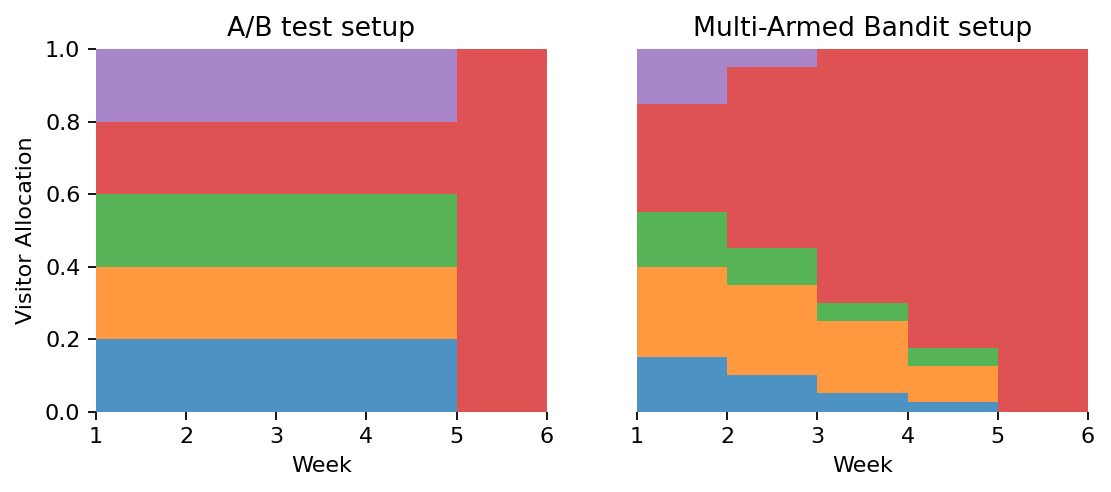

In [99]:
fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=160)

ax[0].stackplot(stacks.index+1,  stacks.values.T, alpha = 0.8, step = 'pre');
ax[1].stackplot(stacks1.index+1,  stacks1.values.T, alpha = 0.8, step = 'pre');

for a in ax:
    a.set_ylim([0,1])
    a.set_xlim([1,6])
    a.set_xlabel('Week')

ax[0].set_title('A/B test setup')
ax[1].set_title('Multi-Armed Bandit setup')
ax[1].set_yticks([])
ax[0].set_ylabel('Visitor Allocation')

for s in ax[0].spines:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)

    